<a href="https://colab.research.google.com/github/seven320/air_pollutants/blob/main/FP001_basic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!nvidia-smi

Thu Apr 14 13:50:33 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import os, sys
COLAB = "google.colab" in sys.modules

if COLAB:
    from google.colab import drive
    from google.colab import output
    drive.mount("/content/drive")

Mounted at /content/drive


In [4]:
# NOTEBOOK_NAME = y



In [5]:
if COLAB:
    !pip install transformers > /dev/null
    !pip install einops > /dev/null
    !pip install timm > /dev/null
    !pip install kaggle > /dev/null
    !pip install kaggle_datasets > /dev/null
    !pip install git+https://github.com/albumentations-team/albumentations
    !pip install tensorflow-determinism
    !pip install -q iterative-stratification
    output.clear()

In [23]:
import gc
import json
import math
import os
import random
import re
import time
import copy
import warnings
from requests import get
from contextlib import contextmanager
from typing import List, Optional, TypeVar, Type

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
from pathlib import Path
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GroupKFold, train_test_split, KFold
from sklearn.preprocessing import RobustScaler
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset
from einops.layers.torch import Rearrange, Reduce
import timm

from tqdm.notebook import tqdm
from transformers import AdamW, get_cosine_schedule_with_warmup
from typing import Optional, Tuple
from xgboost import XGBRegressor
import lightgbm as lgb

In [24]:
warnings.simplefilter('ignore')

In [25]:
if COLAB:    
    NOTEBOOK_NAME = get('http://172.28.0.2:9000/api/sessions').json()[0]['name']
    print(NOTEBOOK_NAME)

FP001-basic


In [26]:
COMPE_NAME = "air_pollutants"
BASE_DIR = f"/content/drive/MyDrive/signate/{COMPE_NAME}"

# KAGGLE ONLY HAS 1, BUT OFFLINE, YOU CAN USE MORE
os.environ["CUDA_VISIBLE_DEVICES"]="0" #0,1,2,3 for four gpu

In [27]:
if COLAB:
    INPUT_DIR = Path(os.path.join(BASE_DIR ,f"input"))
    INPUT_DIR.mkdir(exist_ok=True, parents=True)

    SAVE_DIR = Path(os.path.join(BASE_DIR ,f"models/{NOTEBOOK_NAME}"))
    SAVE_DIR.mkdir(exist_ok=True, parents=True)

    OOF_DIR = Path(os.path.join(BASE_DIR, f"oof/{NOTEBOOK_NAME}"))
    OOF_DIR.mkdir(exist_ok=True, parents = True)

    SUB_DIR = Path(os.path.join(BASE_DIR, f"submission/{NOTEBOOK_NAME}"))
    SUB_DIR.mkdir(exist_ok=True, parents = True)

In [28]:
train_df = pd.read_csv(os.path.join(INPUT_DIR, "train.csv"))
test_df = pd.read_csv(os.path.join(INPUT_DIR, "test.csv"))
sample_df = pd.read_csv(os.path.join(INPUT_DIR, "submit_sample.csv"))

In [29]:
#############
## Utility ##
#############
@contextmanager
def timer(name: str):
    t0 = time.time()
    print(f"[{name}] start")
    yield
    print(f"[{name}] done - elapsed {time.time() - t0:.2f}s")

In [30]:
def seed_everything(seed):
    """
    Seeds basic parameters for reproductibility of results
    
    Arguments:
        seed {int} -- Number of the seed
    """
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def set_seed(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(42)

In [31]:
train_df

,id,year,month,day,Country,City,lat,lon,co_cnt,co_min,...,ws_min,ws_mid,ws_max,ws_var,dew_cnt,dew_min,dew_mid,dew_max,dew_var,pm25_mid
0,1,2019,1,1,Australia,Brisbane,-27.46794,153.02809,38,0.749,...,0.241,1.088,3.101,1.983,17,7.671,10.358,15.112,13.424,19.901
1,2,2019,1,1,Australia,Darwin,-12.46113,130.84185,47,2.594,...,0.828,3.473,7.396,10.411,62,21.324,23.813,24.221,2.021,13.741
2,3,2019,1,1,Australia,Melbourne,-37.81400,144.96332,17,1.190,...,0.000,2.107,8.089,15.719,22,10.309,13.133,15.422,6.355,25.918
3,4,2019,1,1,Australia,Newcastle,-32.92953,151.78010,63,4.586,...,0.284,0.503,3.592,2.485,116,7.146,10.685,13.344,9.417,174.370
4,5,2019,1,1,Australia,Perth,-31.95224,115.86140,47,4.689,...,0.500,0.755,3.396,1.937,93,1.091,3.277,12.272,4.109,167.063
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195936,195937,2021,12,31,United States,Jacksonville,30.33218,-81.65565,12,0.694,...,2.195,2.710,6.125,3.757,12,16.774,22.679,26.058,13.252,16.150
195937,195938,2021,12,31,United States,Las Vegas,36.17497,-115.13722,14,0.528,...,1.002,2.974,6.861,8.354,12,10.432,14.741,15.827,7.078,16.895
195938,195939,2021,12,31,United States,Milwaukee,43.03890,-87.90647,171,1.975,...,0.994,1.087,2.578,0.612,26,2.049,3.531,6.686,5.286,86.299
195939,195940,2021,12,31,Vietnam,Hanoi,21.02450,105.84117,31,2.613,...,1.005,3.058,6.005,6.085,51,1.922,7.443,7.716,4.642,36.523


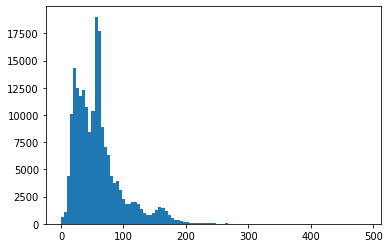

In [32]:
plt.hist(train_df["pm25_mid"], bins = 100)
plt.show()

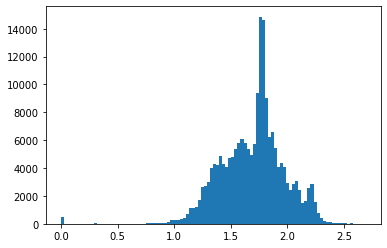

In [33]:
plt.hist(np.log10(train_df["pm25_mid"] + 1), bins = 100)
plt.show()

In [56]:
train_city = train_df["City"].unique().tolist()
test_city = test_df["City"].unique().tolist()

train_city_cnt = len(train_city)
test_city_cnt = len(test_city)

print(f"train city count: {train_city_cnt}")
print(f"test city count: {test_city_cnt}")

print(f"{len(set(train_city) & set(test_city))}")

train city count: 239
test city count: 63
0


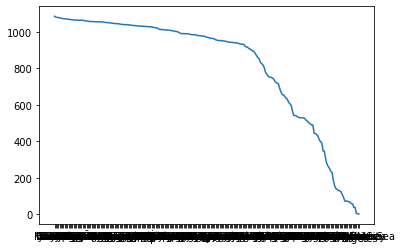

In [58]:
plt.plot(train_df["City"].value_counts())

In [47]:
test_city

array(['Adelaide', 'Sydney', 'Brussels', 'Sarajevo',
       'São José dos Campos', 'Surrey', 'Concepción', 'Santiago',
       'Changchun', 'Chongqing', 'Dongguan', 'Lanzhou', 'Shenyang',
       'Shijiazhuang', 'Wuhan', 'Wuxi', 'Xuchang', 'Rijeka', 'Paris',
       'Kecskemét', 'Ghāziābād', 'Mysore', 'Nagpur', 'Petaẖ Tiqwa',
       'Matsuyama', 'Nagoya', 'Niigata', 'Osaka', 'Cuernavaca',
       'Mexico City', 'Amsterdam', 'Płock', 'Moscow', 'Belgrade',
       'Port Elizabeth', 'Daegu', 'Jeonju', 'Sejong', 'Suwon', 'Burgos',
       'Douliu', 'Tainan', 'Samut Prakan', 'Bursa', 'Trabzon', 'London',
       'Chicago', 'Fresno', 'Tucson', 'Haiphong', 'Kumamoto', 'Saitama',
       'Santa Cruz de Tenerife', 'Charlotte', 'Anyang', 'Karaj',
       'Katowice', 'Málaga', 'Adana', 'Potsdam', 'Nashik', 'Parma',
       'Johannesburg'], dtype=object)

In [34]:
# 人口
# 風
# 地図

In [35]:
import logging
from typing import List, Optional, TypeVar

import pandas as pd

class AbstractFeatureTransformer:
    def __init__(self):
        self.name = self.__class__.__name__

    def fit_transform(self, input_df: pd.DataFrame, y=None):
        self.fit(input_df, y)
        return self.transform(input_df)

    def fit(self, input_df: pd.DataFrame, y=None):
        pass

    def transform(self, input_df: pd.DataFrame) -> pd.DataFrame:
        raise NotImplementedError

Transformer = TypeVar("Transformer", bound=AbstractFeatureTransformer)


def extract_features(input_df: pd.DataFrame,
                     transformers: List[Transformer],
                     fit: bool = True,
                     logger: Optional[logging.Logger] = None):
    feature_dfs = []
    for transformer in transformers:
        # timerはブロックの実行時間を計測するユーティリティ
        with timer(f"Extract features with {transformer.name}", logger):
            if fit:
                feature_dfs.append(transformer.fit_transform(input_df))
            else:
                feature_dfs.append(transformer.transform(input_df))
    all_features = pd.concat(feature_dfs, axis=1)
    return all_features

In [36]:
class Numericals(AbstractFeatureTransformer):
    def transform(self, input_df: pd.DataFrame) -> pd.DataFrame:
        cols = [pd.api.types.is_numeric_dtype(dtype) for dtype in input_df.dtypes]
        return input_df.loc[:, cols]


class LabelEncoding(AbstractFeatureTransformer):
    def __init__(self, columns: List[str]):
        super().__init__()
        self.le_columns = columns
        self.encoders = {
            column: LabelEncoder()
            for column in self.le_columns
        }
        self.__is_fitted = False

    def fit(self, input_df: pd.DataFrame, y: Optional[np.ndarray] = None):
        for column in self.le_columns:
            self.encoders[column].fit(input_df[column].fillna(""))
        self.__is_fitted = True

    def transform(
        self, 
        input_df: pd.DataFrame, 
        y: Optional[np.ndarray] = None
    ) -> pd.DataFrame:
        assert self.__is_fitted, "You need to call `fit` first."
        encoded = {}
        for column in self.le_columns:
            encoded[column] = self.encoders[column].transform(
                input_df[column].fillna(""))
        return pd.DataFrame(encoded)

In [37]:

class AbstractTreeModel:
    def __init__(self, prediction_type="binary"):
        self.model = None
        self.prediction_type = prediction_type

    def train(self,
              params: dict,
              X_train: pd.DataFrame,
              y_train: np.ndarray,
              X_val: pd.DataFrame,
              y_val: np.ndarray,
              train_weights: Optional[np.ndarray] = None,
              val_weights: Optional[np.ndarray] = None,
              train_params: Optional[dict] = None):
        if train_params is None:
            train_params = {}

        model = self._train(
            params,
            X_train, y_train,
            X_val, y_val,
            train_weights, val_weights,
            train_params)
        self.model = model
        return self

    def _train(self,
               params,
               X_train,
               y_train,
               X_val,
               y_val,
               train_weights,
               val_weights,
               train_params):
        raise NotImplementedError

    def predict(self, X: pd.DataFrame) -> np.ndarray:
        raise NotImplementedError

    @property
    def feature_names_(self):
        raise NotImplementedError

    @property
    def feature_importances_(self):
        raise NotImplementedError

    def _check_if_trained(self):
        assert self.model is not None, "You need to train the model first"


class LGBModel(AbstractTreeModel):
    def _train(self,
               params,
               X_train, y_train,
               X_val, y_val,
               train_weights, val_weights,
               train_params):
        trn_data = lgb.Dataset(X_train, y_train, weight=train_weights)
        val_data = lgb.Dataset(X_val, y_val, weight=val_weights)
        model = lgb.train(params=params,
                          train_set=trn_data,
                          valid_sets=[trn_data, val_data],
                          **train_params)
        return model

    def predict(self, X: pd.DataFrame) -> np.ndarray:
        self._check_if_trained()
        return self.model.predict(X, num_iteration=self.model.best_iteration)

    @property
    def feature_names_(self):
        self._check_if_trained()
        return self.model.feature_name()

    @property
    def feature_importances_(self):
        self._check_if_trained()
        return self.model.feature_importance(importance_type="gain")


def get_tree_model(name: str) -> Type[AbstractTreeModel]:
    DEFINED_MODELS = {
        "lgb": LGBModel,
        # 実装していない
        # "xgb": XGBModel,
        # "cat": CatBoostModel
    }
    model = DEFINED_MODELS.get(name)
    if model is None:
        raise ValueError(
            """Invalid model name: {}.
            Pre-defined model names are as follows: {}""".format(
                name,
                ",".join(DEFINED_MODELS.keys())
            ))
    return model

In [39]:
lgb_model = get_tree_model("lgb")